In [14]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [15]:
ratings = pd.read_csv('ratings_small.csv')
del ratings['timestamp']
print(ratings.shape)
ratings.head(5) 

(100004, 3)


,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


<span style="color:pink"> S'assurer que toutes nos données sont dans le bon format: C'est bon 

In [16]:
ratings.dtypes

userId       int64
movieId      int64
rating     float64
dtype: object

  <span style="color:pink"> Chercher les valeurs manquantes,sommer leur nombre puis les classer: on voit qu'on les a pas 


In [17]:
ratings.isnull().sum().sort_values(ascending=False)

rating     0
movieId    0
userId     0
dtype: int64

<span style="color:pink">  On importe notre dataset, et on effectue les tests précedentes, on a les données sous le bon format, pas de valeurs manquantes, et la describtion statistique

In [18]:
#The main Movies Metadata file
meta = pd.read_csv('meta.csv')
meta = meta.loc[:,['id','original_title']]
meta = meta. rename(columns={'id':'movieId'})
meta.head(5)

,movieId,original_title
0,862,Toy Story
1,8844,Jumanji
2,15602,Grumpier Old Men
3,31357,Waiting to Exhale
4,11862,Father of the Bride Part II


In [19]:
meta.dtypes

movieId            int64
original_title    object
dtype: object

In [20]:
meta.isnull().sum().sort_values(ascending=False)

original_title    0
movieId           0
dtype: int64

<span style="color:pink"> On fait une jointure entre les deux dataframes en movieId pour obtenir la dataframe principale

In [21]:
df = pd.merge(ratings,meta,on='movieId')
df.head(5)

,userId,movieId,rating,original_title
0,1,1371,2.5,Rocky III
1,4,1371,4.0,Rocky III
2,7,1371,3.0,Rocky III
3,19,1371,4.0,Rocky III
4,21,1371,3.0,Rocky III


In [22]:
ratings = df.loc[:,['userId', 'movieId', 'rating']]
ratings

,userId,movieId,rating
0,1,1371,2.5
1,4,1371,4.0
2,7,1371,3.0
3,19,1371,4.0
4,21,1371,3.0
...,...,...,...
44989,652,129009,4.0
44990,653,2103,3.0
44991,659,167,4.0
44992,659,563,3.0


## Recommender

In [23]:
Mean = ratings.groupby(by="userId",as_index=False)['rating'].mean()
Rating_avg = pd.merge(ratings,Mean,on='userId',suffixes=('', '_Mean'))
Rating_avg.head()

,userId,movieId,rating,rating_Mean
0,1,1371,2.5,2.333333
1,1,1405,1.0,2.333333
2,1,2105,4.0,2.333333
3,1,2193,2.0,2.333333
4,1,2294,2.0,2.333333


In [24]:
Rating_avg['adg_rating']=Rating_avg['rating']-Rating_avg['rating_Mean']
print(Rating_avg.shape)
Rating_avg.head()

(44994, 5)


,userId,movieId,rating,rating_Mean,adg_rating
0,1,1371,2.5,2.333333,0.166667
1,1,1405,1.0,2.333333,-1.333333
2,1,2105,4.0,2.333333,1.666667
3,1,2193,2.0,2.333333,-0.333333
4,1,2294,2.0,2.333333,-0.333333



    For the above formula we need to find the users who have similar thoughts.so how do we find the similarity?
        ==> we will use Cosine Similarity and see how similar the users are. It is usually calculated over the ratings that both the users have rated in the past.

In [25]:
pivot_table= pd.pivot_table(Rating_avg,values='adg_rating',index='userId',columns='movieId')
# Replacing NaN by item Average
final = pivot_table.fillna(pivot_table.mean(axis=0))
final.head()

movieId,2,3,5,6,11,12,13,14,15,16,17,18,19,20,21,22,24,25,26,27,28,30,35,38,55,58,59,62,63,64,65,66,68,69,70,71,73,74,76,77,...,111759,111913,112460,112582,112655,112735,112767,114044,114060,114464,115210,115877,116977,118900,120637,121113,121491,122924,126420,127098,127728,128606,128846,129009,130450,130452,130980,131830,132961,133365,134158,134368,134569,134881,135536,140174,142507,148652,158238,160718
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-0.159406,-0.412234,-0.327499,0.255092,0.107241,-0.68831,0.293087,-0.102049,-1.123057,0.289254,0.338682,-0.236204,-0.867904,-0.920997,0.020164,-0.243199,-0.426612,0.127083,0.361613,-0.204042,0.590588,0.324731,-0.110112,-1.221658,-0.333454,0.250802,0.110837,0.152261,-0.765637,-1.073367,-1.438845,-1.488627,-0.069437,0.383927,-0.458215,-0.940739,0.357789,-0.543277,-0.183043,0.471337,...,0.137092,-0.964286,-1.329495,0.606906,-0.237991,1.106906,0.302083,-0.237991,0.516959,1.606906,-0.130801,0.137432,-1.122296,-0.117314,-1.810905,-1.737991,-0.006098,-0.327184,-1.588477,-0.6875,0.865591,1.106906,0.605769,-0.134409,-1.588477,-0.095662,0.27027,-0.22973,0.20177,-1.088477,-1.588477,0.212257,0.122222,0.759214,-0.088477,0.621882,0.20177,-1.197917,0.669601,0.606906
2,-0.159406,-0.412234,-0.327499,0.255092,0.107241,-0.68831,0.293087,-0.102049,-1.123057,0.289254,1.482759,-0.236204,-0.867904,-0.920997,0.020164,-0.243199,-0.426612,0.127083,0.361613,-0.204042,0.590588,0.324731,-0.110112,-1.221658,-0.333454,0.250802,0.110837,-0.517241,-0.765637,-1.073367,-1.438845,-1.488627,-0.069437,0.383927,-0.458215,-0.940739,0.357789,-0.543277,-0.183043,0.471337,...,0.137092,-0.964286,-1.329495,0.606906,-0.237991,1.106906,0.302083,-0.237991,0.516959,1.606906,-0.130801,0.137432,-1.122296,-0.117314,-1.810905,-1.737991,-0.006098,-0.327184,-1.588477,-0.6875,0.865591,1.106906,0.605769,-0.134409,-1.588477,-0.095662,0.27027,-0.22973,0.20177,-1.088477,-1.588477,0.212257,0.122222,0.759214,-0.088477,0.621882,0.20177,-1.197917,0.669601,0.606906
3,-0.159406,-0.412234,-0.327499,0.255092,0.107241,-0.68831,0.293087,-0.102049,-1.123057,0.289254,0.338682,-0.236204,-0.867904,-0.920997,0.020164,-0.243199,-0.426612,0.127083,0.361613,-0.204042,0.590588,0.324731,-0.110112,-1.221658,-0.333454,0.250802,0.110837,0.152261,-0.765637,-1.073367,-1.438845,-1.488627,-0.069437,0.383927,-0.458215,-0.940739,0.357789,-0.543277,-0.183043,0.471337,...,0.137092,-0.964286,-1.329495,0.606906,-0.237991,1.106906,0.302083,-0.237991,0.516959,1.606906,-0.130801,0.137432,-1.122296,-0.117314,-1.810905,-1.737991,-0.006098,-0.327184,-1.588477,-0.6875,0.865591,1.106906,0.605769,-0.134409,-1.588477,-0.095662,0.27027,-0.22973,0.20177,-1.088477,-1.588477,0.212257,0.122222,0.759214,-0.088477,0.621882,0.20177,-1.197917,0.669601,0.606906
4,-0.159406,-0.412234,-0.327499,0.255092,0.107241,-0.68831,0.293087,-0.102049,-1.123057,0.289254,0.338682,-0.236204,-0.867904,-0.920997,0.020164,-0.243199,-0.426612,0.127083,0.361613,-0.204042,0.590588,0.324731,-0.110112,-1.221658,-0.333454,0.250802,0.110837,0.152261,-0.765637,-1.073367,-1.438845,-1.488627,-0.069437,0.383927,-0.458215,-0.940739,0.357789,-0.543277,-0.183043,0.471337,...,0.137092,-0.964286,-1.329495,0.606906,-0.237991,1.106906,0.302083,-0.237991,0.516959,1.606906,-0.130801,0.137432,-1.122296,-0.117314,-1.810905,-1.737991,-0.006098,-0.327184,-1.588477,-0.6875,0.865591,1.106906,0.605769,-0.134409,-1.588477,-0.095662,0.27027,-0.22973,0.20177,-1.088477,-1.588477,0.212257,0.122222,0.759214,-0.088477,0.621882,0.20177,-1.197917,0.669601,0.606906
5,-0.159406,0.084906,-0.327499,0.255092,0.107241,-0.68831,0.293087,-0.102049,-1.123057,0.289254,0.338682,-0.236204,-0.867904,-0.920997,0.020164,-0.243199,-0.426612,0.127083,0.361613,-0.204042,0.590588,0.324731,-0.110112,-1.221658,-0.333454,0.250802,0.110837,0.152261,-0.765637,-1.073367,-1.438845,-1.488627,-0.069437,0.383927,-0.458215,-0.940739,0.357789,-0.543277,-0.183043,0.471337,...,0.137092,-0.964286,-1.329495,0.606906,-0.237991,1.106906,0.

In [26]:
# Now, we will calculate the similarity between the users.
cosine = cosine_similarity(final)
np.fill_diagonal(cosine, 0 ) #1 est sa valeur
similarity_ = pd.DataFrame(cosine,index=final.index)
similarity_.columns=final.index
similarity_.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.983854,0.994616,0.977988,0.990937,0.991720,0.989674,0.988072,0.994260,0.995337,0.995674,0.992962,0.996533,0.995471,0.856186,0.997186,0.955891,0.992913,0.961450,0.970714,0.990453,0.979238,0.952573,0.997171,0.993853,0.982297,0.997495,0.989090,0.997824,0.921086,0.996037,0.988452,0.981619,0.988042,0.994493,0.988072,0.994940,0.995609,0.988543,0.997552,...,0.997215,0.996803,0.995866,0.995463,0.995879,0.996494,0.996205,0.993803,0.989492,0.984276,0.992669,0.996579,0.994948,0.994492,0.974510,0.978316,0.977225,0.985741,0.991323,0.996545,0.990445,0.992872,0.975716,0.991106,0.993491,0.995972,0.990381,0.980189,0.993387,0.994356,0.990054,0.998586,0.987268,0.953334,0.989737,0.989608,0.996588,0.997368,0.989619,0.992317
2,0.983854,0.000000,0.982000,0.963752,0.977761,0.978301,0.978818,0.974445,0.980896,0.981274,0.982160,0.979725,0.983173,0.981996,0.839843,0.983753,0.944662,0.979521,0.947058,0.958814,0.976505,0.970354,0.937522,0.982586,0.980453,0.968371,0.984394,0.975646,0.984320,0.911743,0.982540,0.978338,0.968569,0.975092,0.981029,0.972803,0.981231,0.981822,0.974801,0.984045,...,0.983238,0.984562,0.980700,0.981536,0.981717,0.983004,0.982717,0.979549,0.975628,0.968071,0.980362,0.983094,0.981108,0.981174,0.960606,0.963087,0.964178,0.974129,0.977508,0.983056,0.978661,0.978824,0.963800,0.977569,0.979954,0.981359,0.977265,0.965543,0.982027,0.980874,0.976068,0.985155,0.974300,0.935676,0.977813,0.971851,0.982887,0.983909,0.972590,0.979680
3,0.994616,0.982000,0.000000,0.975161,0.988647,0.988998,0.989169,0.984472,0.990624,0.992519,0.993355,0.990760,0.993894,0.993025,0.850890,0.994616,0.954055,0.990187,0.957801,0.967361,0.987074,0.976964,0.950367,0.995041,0.991170,0.978007,0.994031,0.986158,0.994430,0.918213,0.992852,0.987066,0.979714,0.987119,0.991281,0.985070,0.991526,0.992901,0.988172,0.994586,...,0.992728,0.994065,0.993651,0.992644,0.993126,0.993861,0.993982,0.992321,0.986773,0.980450,0.989942,0.993947,0.992286,0.991759,0.970511,0.974167,0.973882,0.983174,0.988600,0.993616,0.987858,0.988123,0.974386,0.988392,0.990665,0.993042,0.989083,0.976479,0.992949,0.991668,0.985855,0.996036,0.984253,0.948988,0.988276,0.987687,0.993289,0.995023,0.986106,0.989302
4,0.977988,0.963752,0.975161,0.000000,0.971745,0.972236,0.971920,0.970062,0.974720,0.975988,0.976919,0.974601,0.976579,0.975566,0.837744,0.977714,0.936017,0.974014,0.945639,0.953105,0.970813,0.959511,0.934599,0.977389,0.975265,0.962382,0.978088,0.970040,0.978553,0.907006,0.976371,0.969312,0.964423,0.967552,0.974731,0.969090,0.975874,0.976253,0.969103,0.978235,...,0.978033,0.977748,0.976711,0.976240,0.976610,0.977250,0.976986,0.973981,0.970855,0.965957,0.973527,0.978384,0.975494,0.974618,0.951239,0.960107,0.957169,0.967826,0.971118,0.977581,0.971201,0.974791,0.957147,0.971959,0.974494,0.976207,0.971292,0.960149,0.973858,0.975147,0.970520,0.979144,0.967682,0.940122,0.969428,0.971727,0.977146,0.978620,0.971733,0.973163
5,0.990937,0.977761,0.988647,0.971745,0.000000,0.985022,0.984288,0.981083,0.987361,0.989376,0.989849,0.986693,0.991295,0.989083,0.848017,0.990949,0.948486,0.986604,0.953879,0.968062,0.983965,0.973503,0.946414,0.991147,0.987782,0.973350,0.990870,0.983744,0.991421,0.913740,0.990540,0.982521,0.974687,0.982719,0.987610,0.980992,0.988497,0.990109,0.982607,0.991142,...,0.990619,0.990453,0.987924,0.988430,0.989438,0.989739,0.989803,0.988069,0.982537,0.979447,0.986292,0.989684,0.989083,0.989155,0.967039,0.971630,0.972223,0.980235,0.984788,0.990060,0.984036,0.985326,0.971618,0.985337,0.987431,0.989595,0.983992,0.973376,0.987005,0.987982,0.984507,0.992174,0.981146,0.950493,0.983158,0.982908,0.990185,0.990967,0.982782,0.986658


    Now we can calculate the similaritry between users but it's not good with a large scale data.
    If we have more than millions(1M*1M) of users in its database and so while calculating the score for any item it would not be a good solution or method to look at all the other users all the time. Hence to overcome this we use the notion of neighborhood. This includes only the set of (K) similar users for a particular user.

In [27]:
def find_n_neighbours(df,n):
    order = np.argsort(df.values, axis=1)[:, :n]
    df = df.apply(lambda x: pd.Series(x.sort_values(ascending=False)
           .iloc[:n].index, 
          index=['top{}'.format(i) for i in range(1, n+1)]), axis=1)
    return df

In [46]:
# top 7 neighbours for each user, we have choosen 7 with elbow method (next part)
sim_user_4 = find_n_neighbours(similarity_,4)
sim_user_4

,top1,top2,top3,top4
userId,,,,
1,663,448,314,485
2,448,314,663,622
3,663,448,314,622
4,663,448,576,71
5,229,663,448,314
...,...,...,...,...
667,513,663,413,448
668,663,314,438,448
669,663,314,448,485


In [29]:
def get_user_similar_items(user1, user2 ):
    common_items = Rating_avg[Rating_avg.userId == user1].merge(
    Rating_avg[Rating_avg.userId == user2],
    on = "movieId",
    how = "inner" )
    return common_items.merge( meta, on = 'movieId' )

     On choisit le premier user et son plus proche voisin, et on voit que leurs évaluation est presque la meme

In [47]:
a = get_user_similar_items(4,319)
a = a.loc[ : , ['rating_x','rating_y','movieId']]
a

,rating_x,rating_y,movieId
0,4.0,4.0,153
1,5.0,3.0,349
2,5.0,4.0,480
3,5.0,5.0,141
4,3.0,3.0,380
5,1.0,2.0,435


![image.png](attachment:f1a5f0c5-1c1f-4381-9a18-63d223141af3.png)

In [48]:
def Score_user_item(user,item):
    sim_user_4 = find_n_neighbours(similarity_,4)
    a= sim_user_4[sim_user_4.index==user].values.squeeze()
    c = final.loc[:,item]
    d = c[c.index.isin(a)]
    index = d.index.values.squeeze().tolist()
    avg_user = Mean.loc[Mean['userId'] == user,'rating'] #bar(r_u)
    corr = similarity_.loc[user,index]
    fin = pd.concat([d, corr], axis=1)
    fin.columns = ['adg_score','correlation']
    fin['score']=fin.apply(lambda x:x['adg_score'] * x['correlation'],axis=1)
    nume = fin['score'].sum()                                
    deno = fin['correlation'].sum()
    final_score = avg_user + (nume/deno)
    return final_score.values[0]

In [49]:
score = Score_user_item(4,141)
score

4.2296654429662475

### Elbow method to choose the optimal k

In [33]:
# top k neighbours for each user
sim_user_ = []
for i in range(20):
    sim_user_.append(find_n_neighbours(similarity_,i+1))

In [34]:
def Score_user_item_k(user,item,k):
    sim_user_k = sim_user_[k]
    a= sim_user_k[sim_user_k.index==user].values.squeeze()
    c = final.loc[:,item]
    d = c[c.index.isin(a)]
    index = d.index.values.squeeze().tolist()
    
    avg_user = Mean.loc[Mean['userId'] == user,'rating'] #bar(r_u)

    corr = similarity_.loc[user,index]
    fin = pd.concat([d, corr], axis=1)
    fin.columns = ['adg_score','correlation']
    fin['score']=fin.apply(lambda x:x['adg_score'] * x['correlation'],axis=1)
    nume = fin['score'].sum()                                
    deno = fin['correlation'].sum()
    final_score = avg_user + (nume/deno)
    return final_score.values[0]

In [35]:
from tqdm import tqdm

In [36]:
for k in tqdm(range(1,20)):
    ratings['score_norm_%s'%k] = 0.0
    for i in range(len(ratings)):
        ratings['score_norm_%s'%k][i] = Score_user_item_k(ratings['userId'][i],ratings['movieId'][i],k)
        
comparaison_k = ratings
comparaison_k

100%|██████████| 19/19 [1:09:59<00:00, 221.05s/it]


,userId,movieId,rating,score_norm_1,score_norm_2,score_norm_3,score_norm_4,score_norm_5,score_norm_6,score_norm_7,score_norm_8,score_norm_9,score_norm_10,score_norm_11,score_norm_12,score_norm_13,score_norm_14,score_norm_15,score_norm_16,score_norm_17,score_norm_18,score_norm_19
0,1,1371,2.5,1.967574,1.967574,1.967574,1.967574,1.967574,1.967574,1.967574,1.967574,1.967574,1.967574,1.967574,1.967574,1.967574,1.967574,1.967574,1.967574,1.967574,1.967574,1.967574
1,4,1371,4.0,3.906171,3.906171,3.906171,3.906171,3.906171,3.906171,3.906171,3.906171,3.906171,3.906171,3.906171,3.906171,3.906171,3.906171,3.906171,3.906171,3.906171,3.906171,3.906171
2,7,1371,3.0,3.003806,3.003806,3.003806,3.003806,3.003806,3.003806,3.003806,3.003806,3.003806,3.003806,3.003806,3.003806,3.003806,3.003806,3.003806,3.003806,3.003806,3.003806,3.003806
3,19,1371,4.0,3.106015,3.106015,3.106015,3.106015,3.106015,3.106015,3.106015,3.106015,3.106015,3.106015,3.106015,3.106015,3.106015,3.106015,3.106015,3.106015,3.103767,3.103885,3.103991
4,21,1371,3.0,3.062812,3.062812,3.062812,3.062812,3.062812,3.062812,3.062812,3.062812,3.062812,3.062812,3.062812,3.062812,3.062812,3.062812,3.062812,3.062812,3.062812,3.062812,3.062812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44989,652,129009,4.0,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
44990,653,2103,3.0,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
44991,659,167,4.0,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
44992,659,563,3.0,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


In [38]:
error_rate = []
for k in range(1,20):
    error_rate.append((np.square(np.subtract(ratings['rating'],ratings['score_norm_%s'%k])).mean())/k)

error_rate


[0.6695613718251588,
 0.3358008049536201,
 0.22440628330830073,
 0.16863421580764087,
 0.13513265288628357,
 0.11281906745395844,
 0.09685817134056088,
 0.08488308723069161,
 0.07555989590933203,
 0.06808969902866156,
 0.06196546107827965,
 0.05686096317939846,
 0.05254538862305773,
 0.04882501326763355,
 0.045600983299562185,
 0.04278530760639192,
 0.040293720782320464,
 0.03808017615065095,
 0.03609490022864902]

Text(0, 0.5, 'Error Rate')

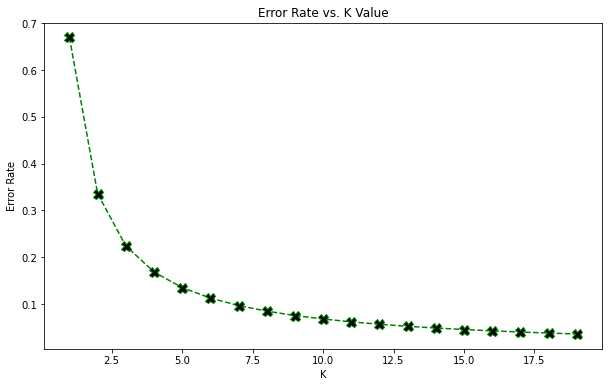

In [39]:
plt.figure(figsize=(10,6))
plt.plot(range(1,20),error_rate,color='green', linestyle='dashed', marker='X',
         markerfacecolor='black', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [40]:
ratings

,userId,movieId,rating,score_norm_1,score_norm_2,score_norm_3,score_norm_4,score_norm_5,score_norm_6,score_norm_7,score_norm_8,score_norm_9,score_norm_10,score_norm_11,score_norm_12,score_norm_13,score_norm_14,score_norm_15,score_norm_16,score_norm_17,score_norm_18,score_norm_19
0,1,1371,2.5,1.967574,1.967574,1.967574,1.967574,1.967574,1.967574,1.967574,1.967574,1.967574,1.967574,1.967574,1.967574,1.967574,1.967574,1.967574,1.967574,1.967574,1.967574,1.967574
1,4,1371,4.0,3.906171,3.906171,3.906171,3.906171,3.906171,3.906171,3.906171,3.906171,3.906171,3.906171,3.906171,3.906171,3.906171,3.906171,3.906171,3.906171,3.906171,3.906171,3.906171
2,7,1371,3.0,3.003806,3.003806,3.003806,3.003806,3.003806,3.003806,3.003806,3.003806,3.003806,3.003806,3.003806,3.003806,3.003806,3.003806,3.003806,3.003806,3.003806,3.003806,3.003806
3,19,1371,4.0,3.106015,3.106015,3.106015,3.106015,3.106015,3.106015,3.106015,3.106015,3.106015,3.106015,3.106015,3.106015,3.106015,3.106015,3.106015,3.106015,3.103767,3.103885,3.103991
4,21,1371,3.0,3.062812,3.062812,3.062812,3.062812,3.062812,3.062812,3.062812,3.062812,3.062812,3.062812,3.062812,3.062812,3.062812,3.062812,3.062812,3.062812,3.062812,3.062812,3.062812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44989,652,129009,4.0,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
44990,653,2103,3.0,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
44991,659,167,4.0,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
44992,659,563,3.0,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


In [51]:
df_rec = ratings.iloc[:,[0,1,6]]
df_rec = pd.merge(df_rec,meta,on='movieId')
df_rec

,userId,movieId,score_norm_4,original_title
0,1,1371,1.967574,Rocky III
1,4,1371,3.906171,Rocky III
2,7,1371,3.003806,Rocky III
3,19,1371,3.106015,Rocky III
4,21,1371,3.062812,Rocky III
...,...,...,...,...
44999,652,129009,4.000000,Love Is a Ball
45000,653,2103,3.000000,Solaris
45001,659,167,4.000000,K-PAX
45002,659,563,3.000000,Starship Troopers


# Recommand Now

In [46]:
import pickle

In [47]:
with open('df_rec .pickle', 'rb') as handle:
    df_rec = pickle.load(handle)
print(df_rec)

       userId  movieId  score_norm_4     original_title
0           1     1371      1.967574          Rocky III
1           4     1371      3.906171          Rocky III
2           7     1371      3.003806          Rocky III
3          19     1371      3.106015          Rocky III
4          21     1371      3.062812          Rocky III
...       ...      ...           ...                ...
44999     652   129009      4.000000     Love Is a Ball
45000     653     2103      3.000000            Solaris
45001     659      167      4.000000              K-PAX
45002     659      563      3.000000  Starship Troopers
45003     665      129      3.000000           千と千尋の神隠し

[45004 rows x 4 columns]


In [48]:
def collab_recommander(user):
    return df_rec[df_rec['userId'] == user].sort_values(by=['score_norm_4'], ascending=False).loc[:,["original_title"]].head(10)

In [49]:
collab_recommander(652)

,original_title
44986,The Return of Doctor X
44990,Lion of the Desert
44988,Anchorman: The Legend of Ron Burgundy
44998,8:46
44989,Brigham City
44996,Mud
43021,Carts of Darkness
35284,Irma la Douce
33204,Le fabuleux destin d'Amélie Poulain
44270,Tanguy
